In [11]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
df = pd.read_csv('./housing.csv')

In [13]:
df.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


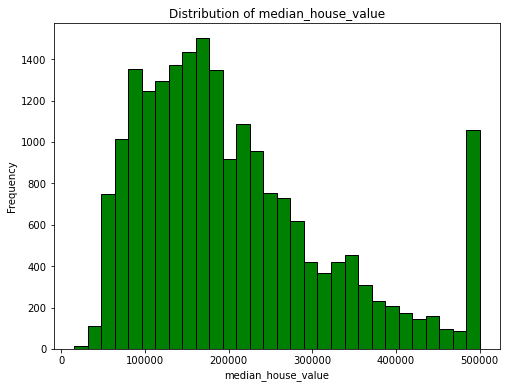

In [19]:
plt.figure(figsize=(8, 6))

sns.histplot(df.median_house_value, bins=30, color='green', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('median_house_value')
plt.title('Distribution of median_house_value')
plt.show()

In [22]:
columns = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

df = df[columns]

# Question 1

In [31]:
for col in columns:
    print(f'{col} -> number of missing values {df[col].isna().sum()}')

latitude -> number of missing values 0
longitude -> number of missing values 0
housing_median_age -> number of missing values 0
total_rooms -> number of missing values 0
total_bedrooms -> number of missing values 207
population -> number of missing values 0
households -> number of missing values 0
median_income -> number of missing values 0
median_house_value -> number of missing values 0


# Question 2

In [32]:
df['population'].median()

1166.0

# Question 3

## Train test split

In [122]:
def train_test_split(df, seed=42):
    np.random.seed(seed)
    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    y_train_orig = df_train['median_house_value'].values
    y_val_orig = df_val['median_house_value'].values
    y_test_orig = df_test['median_house_value'].values

    y_train = np.log1p(df_train['median_house_value'].values)
    y_val = np.log1p(df_val['median_house_value'].values)
    y_test = np.log1p(df_test['median_house_value'].values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    
    return df_train, df_val, df_test, y_train, y_val, y_test

In [123]:
df_train, df_val, df_test, y_train, y_val, y_test = train_test_split(df, seed = 42)
print(f'sizes of datasets train = {df_train.shape[0]}, val = {df_val.shape[0]}, test = {df_test.shape[0]}')

sizes of datasets train = 12384, val = 4128, test = 4128


In [124]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def fill_df(train, val, test, fill_val=0):
    train = train.fillna(fill_val)
    val = val.fillna(fill_val)
    test = test.fillna(fill_val)
    return train, val, test

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [125]:
train1, val1, test1 = fill_df(df_train, df_val, df_test, fill_val=0)

mean_bedroom_train = df_train['total_bedrooms'].mean()
train2, val2, test2 = fill_df(df_train, df_val, df_test, fill_val=mean_bedroom_train)

In [126]:
w_01, w1 = train_linear_regression(train1, y_train)

w_02, w2 = train_linear_regression(train2, y_train)

In [127]:
pred1_train = w_01 + train1.values.dot(w1)
pred2_train = w_02 + train2.values.dot(w2)

pred1_val = w_01 + val1.values.dot(w1)
pred2_val = w_02 + val2.values.dot(w2)

pred1_test = w_01 + test1.values.dot(w1)
pred2_test = w_02 + test2.values.dot(w2)

In [128]:
print(f'fill missing values with 0.')
print(f'RMSE: train = {round(rmse(pred1_train, y_train), 2)}, val = {round(rmse(pred1_val,y_val), 2)}, test = {round(rmse(pred1_test,y_test), 2)}')

print('\n')
print(f'fill missing values with mean.')
print(f'RMSE: train = {round(rmse(pred2_train, y_train), 2)}, val = {round(rmse(pred2_val,y_val), 2)}, test = {round(rmse(pred2_test,y_test), 2)}')

fill missing values with 0.
RMSE: train = 0.34, val = 0.33, test = 0.35


fill missing values with mean.
RMSE: train = 0.34, val = 0.33, test = 0.35


Both filling with 0 and filling with mean are equally good in terms of validation rmse

# Question 4

In [129]:
r_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [130]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [131]:
train1, val1, test1 = fill_df(df_train, df_val, df_test, fill_val=0)

In [132]:
for r in r_values:
    w_0, w = train_linear_regression_reg(train1, y_train, r=r)
    pred_train = w_0 + train1.values.dot(w)

    pred_val = w_0 + val1.values.dot(w)
    
    pred_test = w_0 + test1.values.dot(w)
    print(f'r = {r}, RMSE: val loss = {round(rmse(pred_val,y_val), 2)}')
    

r = 0, RMSE: val loss = 0.33
r = 1e-06, RMSE: val loss = 0.33
r = 0.0001, RMSE: val loss = 0.33
r = 0.001, RMSE: val loss = 0.33
r = 0.01, RMSE: val loss = 0.33
r = 0.1, RMSE: val loss = 0.33
r = 1, RMSE: val loss = 0.33
r = 5, RMSE: val loss = 0.34
r = 10, RMSE: val loss = 0.34


# Question 5

In [133]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_values = []
for seed in seeds:
    np.random.seed(seed)
    df_train, df_val, df_test, y_train, y_val, y_test = train_test_split(df, seed = seed)
    train1, val1, test1 = fill_df(df_train, df_val, df_test, fill_val=0)
    w_0, w1 = train_linear_regression(train1, y_train)
    pred_val = w_0 + val1.values.dot(w1)
    loss = rmse(pred_val,y_val)
    rmse_values.append(loss)
    print(f'seed = {seed}, rmse loss = {loss}')

seed = 0, rmse loss = 0.33884304805295895
seed = 1, rmse loss = 0.33623872559558743
seed = 2, rmse loss = 0.3320912318844027
seed = 3, rmse loss = 0.3405153609035518
seed = 4, rmse loss = 0.3389024066572691
seed = 5, rmse loss = 0.34348667257195153
seed = 6, rmse loss = 0.3451980953098988
seed = 7, rmse loss = 0.3395989927404382
seed = 8, rmse loss = 0.346623087319281
seed = 9, rmse loss = 0.3365926124192122


In [154]:
print(f'std = {round(np.std(rmse_values), 3)}')

std = 0.004


# Question 6

In [146]:
np.random.seed(seed)
df_train, df_val, df_test, y_train, y_val, y_test = train_test_split(df, seed = 9)


In [147]:
y_train.shape, y_val.shape

((12384,), (4128,))

In [148]:
frames = [df_train, df_val]
frames_y = [y_train, y_val]

new_df_train = pd.concat(frames)

y_train = np.concatenate((y_train, y_val))

In [150]:
train = new_df_train.fillna(0)

test = df_test.fillna(0)

w0, w1 = train_linear_regression_reg(train, y_train, r=0.001)

In [153]:
pred_test = w_0 + test.values.dot(w1)
loss = rmse(pred_test,y_test)

print(f'test rmse loss = {loss}')

test rmse loss = 0.34822928298087075
